In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [25]:
dataset = pd.read_csv("data/cleaned_5250.csv")
missing_values_idx = dataset.isna().any(axis=1)
clean_dataset = dataset[~missing_values_idx]

In [26]:
num_obeservation = 4000
df = clean_dataset.iloc[range(num_obeservation)]
full_df = df.copy()
df = df.drop("name", axis=1)

In [27]:
# mass transformation: The dataset contains a mass calculation based on two planets. We unify that into a single mass variable
jupiter_mass_kg = 1.898 * 10**27 #kg
jupiter_radius_km = 69911 #km
earth_mass_kg = 5.972 * 10**24
earth_radius_km = 6378
df["mass_wrt"] = np.where(df["mass_wrt"] == "Jupiter", jupiter_mass_kg, earth_mass_kg)
df["mass"] = np.multiply(df["mass_multiplier"], df["mass_wrt"])
df["radius_wrt"] = np.where(df["radius_wrt"] == "Jupiter", jupiter_radius_km, earth_radius_km)
df["radius"] = np.multiply(df["radius_multiplier"], df["radius_wrt"])
df = df.drop(["mass_wrt", "radius_wrt", "mass_multiplier", "radius_multiplier"], axis=1)
print(df, df.shape)

      distance  stellar_magnitude   planet_type  discovery_year  \
0        304.0            4.72307     Gas Giant            2007   
1        409.0            5.01300     Gas Giant            2009   
2        246.0            5.23133     Gas Giant            2008   
3         58.0            6.61935     Gas Giant            2002   
4         69.0            6.21500     Gas Giant            1996   
...        ...                ...           ...             ...   
4260    7849.0           16.06200  Neptune-like            2016   
4261    3197.0           14.67200  Neptune-like            2016   
4262    2942.0           15.57600  Neptune-like            2016   
4263    3601.0           15.42400  Neptune-like            2016   
4264    3081.0           13.69300  Neptune-like            2016   

      orbital_radius  orbital_period  eccentricity detection_method  \
0           1.290000        0.892539          0.23  Radial Velocity   
1           1.530000        1.400000          0.08  R

In [28]:
outlier = df.iloc[np.where(df["mass"] > 10**30)]
df = df.drop(outlier.index)

In [29]:

planet_type = df["planet_type"]
encoded_df = df.copy()
#we encode the categorical variables, to make it digestable for the training stage later
encoded_df["detection_method"] = encoded_df["detection_method"].astype("category").cat.codes
encoded_df["planet_type"] = encoded_df["planet_type"].astype("category").cat.codes
encoded_df["discovery_year"] = encoded_df["discovery_year"].astype("category").cat.codes

#we have a separate df, so that the standardization is only done for the non-categorical variables
df_without_type = encoded_df.drop(["planet_type", "detection_method", "discovery_year"] , axis=1)

In [30]:
planet_cats = df["planet_type"].astype("category")
print(planet_cats.cat.categories) 
detection_cats = df["detection_method"].astype("category")
print(detection_cats.cat.categories)
discovery_cats = df["discovery_year"].astype("category")
print(discovery_cats.cat.categories) 


Index(['Gas Giant', 'Neptune-like', 'Super Earth', 'Terrestrial'], dtype='object')
Index(['Astrometry', 'Direct Imaging', 'Disk Kinematics',
       'Eclipse Timing Variations', 'Orbital Brightness Modulation',
       'Radial Velocity', 'Transit', 'Transit Timing Variations'],
      dtype='object')
Index([1995, 1996, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021, 2022, 2023],
      dtype='int64')


In [31]:
df_train = df_without_type.copy().drop("orbital_period", axis=1)
df_train["planet_type"] = df["planet_type"]
df_train = pd.get_dummies(df_train, columns=['planet_type'])

In [32]:
# Define features, and target variable
X = df_train.drop(columns=['mass']).values
y = df_train['mass'].values
print(X.shape, y.shape)

(3999, 9) (3999,)


In [33]:
def standardize_data(X_train_orig, X_test_orig, y_train_orig, y_test_orig, numerical_indices, encoded_indices):

    # Scale Numerical Features
    X_train_numerical = X_train_orig[:, numerical_indices]
    X_test_numerical = X_test_orig[:, numerical_indices]

    feature_scaler = StandardScaler()
    X_train_scaled_numerical = feature_scaler.fit_transform(X_train_numerical)
    X_test_scaled_numerical = feature_scaler.transform(X_test_numerical)

    # Recombine scaled numerical + encoded parts
    X_train_scaled = np.concatenate([X_train_scaled_numerical, X_train_orig[:, encoded_indices]], axis=1)
    X_test_scaled = np.concatenate([X_test_scaled_numerical, X_test_orig[:, encoded_indices]], axis=1)

    # Scale Target Variable
    mu_y = y_train_orig.mean()
    sigma_y = y_train_orig.std()
    epsilon = 1e-8

    y_train_scaled = (y_train_orig - mu_y) / (sigma_y + epsilon)
    y_test_scaled = (y_test_orig - mu_y) / (sigma_y + epsilon)

    return X_train_scaled.astype(np.float32), X_test_scaled.astype(np.float32), y_train_scaled, y_test_scaled, feature_scaler, mu_y, sigma_y


In [34]:
lambdas = np.logspace(-6, 4, 100)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

train_errors = []
test_errors = []
coeff = []

In [35]:
# Define column indices
total_columns = X.shape[1]
numerical_indices = list(range(total_columns - 4))
encoded_indices = list(range(total_columns - 4, total_columns))

# A safety check in case there are no numerical columns
has_numerical_features = len(numerical_indices) > 0

for lam in lambdas:
    
    fold_train_errors = []
    fold_test_errors = []
    
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Initialize processed arrays with the one-hot encoded parts
        X_train, X_test, y_train, y_test, a, b, c = standardize_data(
            X_train, X_test, y_train, y_test,
            numerical_indices, encoded_indices
        )

        # Fit the model on the correctly processed data
        ridge = Ridge(alpha=lam)
        ridge.fit(X_train, y_train)
        
        y_pred_train = ridge.predict(X_train)
        y_pred_test = ridge.predict(X_test)
        
        fold_train_errors.append(mean_squared_error(y_train, y_pred_train))
        fold_test_errors.append(mean_squared_error(y_test, y_pred_test))
    
    train_errors.append(np.mean(fold_train_errors))
    test_errors.append(np.mean(fold_test_errors))
    coeff.append(ridge.coef_)

/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.01057e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.33454e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.01057e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.33454e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.010

Optimal lambda = 3944.2061
Minimum Cross-Validation error = 0.9788
Optimal coefficients = [ 0.01481999 -0.0342379   0.02241286  0.04231808  0.12825069  0.05619033
 -0.03336674 -0.02012915 -0.00269449]


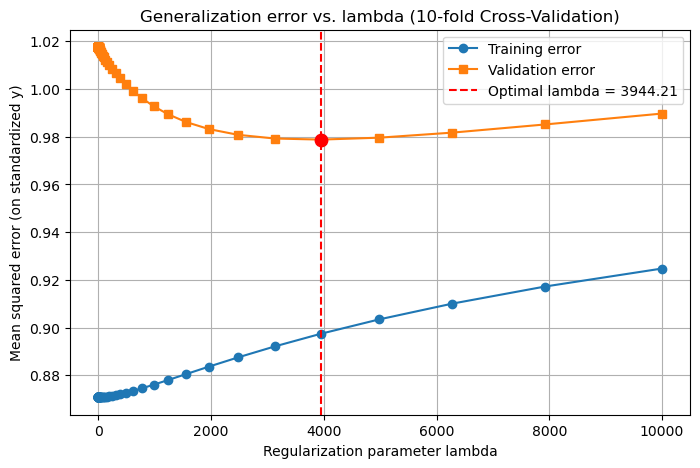

In [36]:
#optimal lambda
optimal_idx = np.argmin(test_errors)
optimal_lambda = lambdas[optimal_idx]
optimal_error = test_errors[optimal_idx]
optimal_coeff = coeff[optimal_idx]

print(f"Optimal lambda = {optimal_lambda:.4f}")
print(f"Minimum Cross-Validation error = {optimal_error:.4f}")
print(f"Optimal coefficients = {optimal_coeff}")
plt.figure(figsize=(8, 5))
plt.plot(lambdas, train_errors, marker='o', label='Training error')
plt.plot(lambdas, test_errors, marker='s', label='Validation error')

# Highlight optimal lambda
plt.axvline(optimal_lambda, color='red', linestyle='--', label=f'Optimal lambda = {optimal_lambda:.2f}')
plt.scatter(optimal_lambda, optimal_error, color='red', s=80, zorder=5)

# Labels and legend
plt.xlabel('Regularization parameter lambda')
plt.ylabel('Mean squared error (on standardized y)')
plt.title('Generalization error vs. lambda (10-fold Cross-Validation)')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
columns_to_log = ["distance", "orbital_period", "orbital_radius", "radius", "mass"]
for col in columns_to_log:
    df[col] = np.log10(df[col])

In [38]:

planet_type = df["planet_type"]
encoded_df = df.copy()
#we encode the categorical variables, to make it digestable for the training stage later
encoded_df["detection_method"] = encoded_df["detection_method"].astype("category").cat.codes
encoded_df["planet_type"] = encoded_df["planet_type"].astype("category").cat.codes
encoded_df["discovery_year"] = encoded_df["discovery_year"].astype("category").cat.codes

#we have a separate df, so that the standardization is only done for the non-categorical variables
df_without_type = encoded_df.drop(["planet_type", "detection_method", "discovery_year"] , axis=1)

In [39]:
df_train = df_without_type.copy().drop("orbital_period", axis=1)
df_train["planet_type"] = df["planet_type"]
df_train = pd.get_dummies(df_train, columns=['planet_type'])

In [40]:
# Define features, and target variable
X = df_train.drop(columns=['mass']).values
y = df_train['mass'].values
print(X.shape, y.shape)

(3999, 9) (3999,)


In [41]:
lambdas = np.logspace(-6, 2, 100)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

train_errors = []
test_errors = []
coeff = []

In [42]:
# Define column indices
total_columns = X.shape[1]
numerical_indices = list(range(total_columns - 4))
encoded_indices = list(range(total_columns - 4, total_columns))

# A safety check in case there are no numerical columns
has_numerical_features = len(numerical_indices) > 0

for lam in lambdas:
    
    fold_train_errors = []
    fold_test_errors = []
    
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Initialize processed arrays with the one-hot encoded parts
        X_train, X_test, y_train, y_test, a, b, c = standardize_data(
            X_train, X_test, y_train, y_test,
            numerical_indices, encoded_indices
        )

        # Fit the model on the correctly processed data
        ridge = Ridge(alpha=lam)
        ridge.fit(X_train, y_train)
        
        y_pred_train = ridge.predict(X_train)
        y_pred_test = ridge.predict(X_test)
        
        fold_train_errors.append(mean_squared_error(y_train, y_pred_train))
        fold_test_errors.append(mean_squared_error(y_test, y_pred_test))
    
    train_errors.append(np.mean(fold_train_errors))
    test_errors.append(np.mean(fold_test_errors))
    coeff.append(ridge.coef_)

/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.75012e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.89035e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.27471e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.63377e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.750

Optimal lambda = 0.9545
Minimum Cross-Validation error = 0.1049
Optimal coefficients = [ 0.03432924 -0.0333691   0.13701029  0.04212945  0.54578656  0.57035553
 -0.09589361 -0.07211914 -0.40484402]


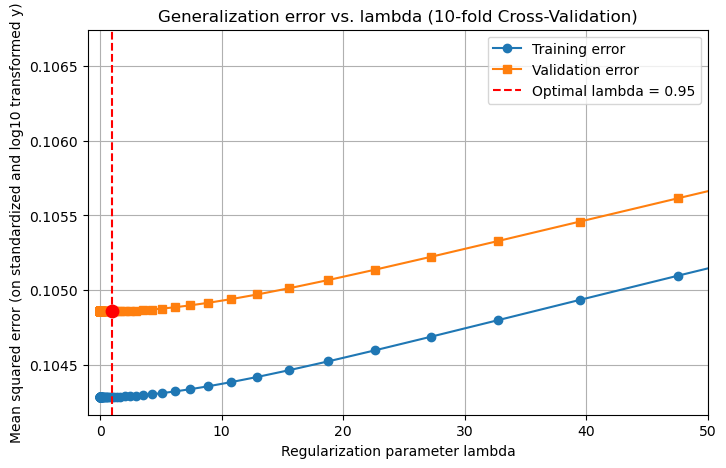

In [43]:
#optimal lambda
optimal_idx = np.argmin(test_errors)
optimal_lambda = lambdas[optimal_idx]
optimal_error = test_errors[optimal_idx]
optimal_coeff = coeff[optimal_idx]

print(f"Optimal lambda = {optimal_lambda:.4f}")
print(f"Minimum Cross-Validation error = {optimal_error:.4f}")
print(f"Optimal coefficients = {optimal_coeff}")

plt.figure(figsize=(8, 5))
plt.plot(lambdas, train_errors, marker='o', label='Training error')
plt.plot(lambdas, test_errors, marker='s', label='Validation error')

# Highlight optimal lambda
plt.axvline(optimal_lambda, color='red', linestyle='--', label=f'Optimal lambda = {optimal_lambda:.2f}')
plt.scatter(optimal_lambda, optimal_error, color='red', s=80, zorder=5)

# Labels and legend
plt.xlim(-1, 50)
plt.xlabel('Regularization parameter lambda')
plt.ylabel('Mean squared error (on standardized and log10 transformed y)')
plt.title('Generalization error vs. lambda (10-fold Cross-Validation)')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define the column indices for numerical and encoded features
total_columns = X.shape[1]
numerical_indices = list(range(total_columns - 4))
encoded_indices = list(range(total_columns - 4, total_columns))

# Isolate the numerical parts from the new splits
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, mu_y, sigma_y = standardize_data(
    X_train_orig, X_test_orig, y_train_orig, y_test_orig,
    numerical_indices, encoded_indices
)


print("--- Final Model Training ---")
print(f"Using optimal lambda: {optimal_lambda}")

# Initialize the model with the best lambda
ridge = Ridge(alpha=optimal_lambda)
ridge.fit(X_train_scaled, y_train_scaled)

# Store the final coefficients and intercept
coeffs = ridge.coef_
intercept = ridge.intercept_

# Make predictions on the scaled training and test sets
y_pred_train_scaled = ridge.predict(X_train_scaled)
y_pred_test_scaled = ridge.predict(X_test_scaled)

train_error_scaled = mean_squared_error(y_train_scaled, y_pred_train_scaled)
test_error_scaled = mean_squared_error(y_test_scaled, y_pred_test_scaled)

print(f"\nFinal training MSE (on scaled data): {train_error_scaled:.4f}")
print(f"Final test MSE (on scaled data): {test_error_scaled:.4f}")
print(f"\nModel Coefficients: {coeffs}")
print(f"Model Intercept: {intercept}")

--- Final Model Training ---
Using optimal lambda: 0.9545484566618347

Final training MSE (on scaled data): 0.0984
Final test MSE (on scaled data): 0.1221

Model Coefficients: [ 0.04580926 -0.0520371   0.13467312  0.04832492  0.5546862   0.5492336
 -0.083919   -0.05048667 -0.4118519 ]
Model Intercept: -0.08011260628700256


Ridge Regression Coefficients:
                 Feature  Coefficient
                  radius     0.554686
   planet_type_Gas Giant     0.549234
 planet_type_Terrestrial    -0.411852
          orbital_radius     0.134673
planet_type_Neptune-like    -0.083919
       stellar_magnitude    -0.052037
  planet_type_SuperEarth    -0.050487
            eccentricity     0.048325
                distance     0.045809

Intercept: -0.0801
Train Error (MSE): 0.0984
Test Error (MSE): 0.1221


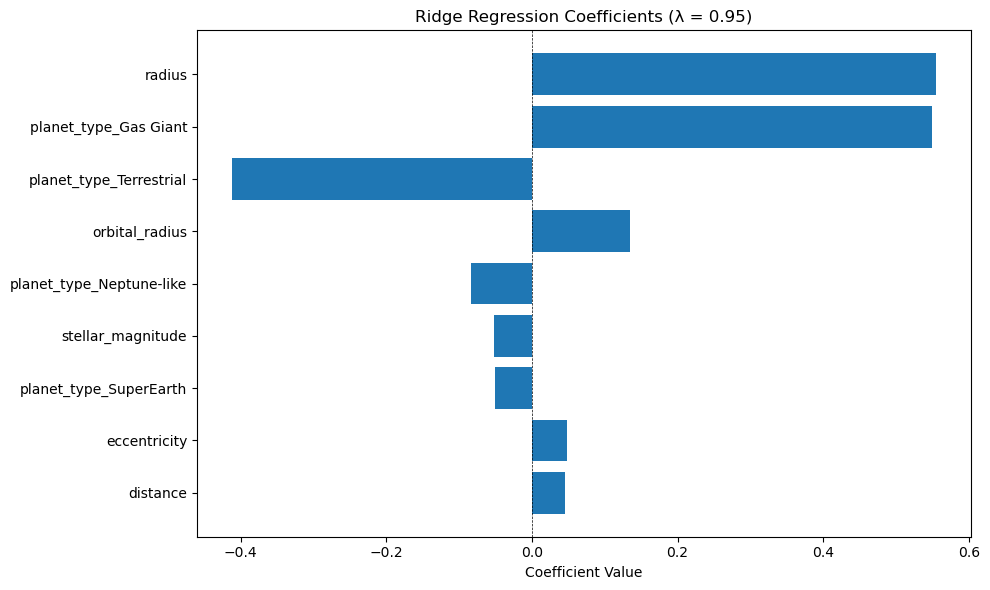

,Feature,Coefficient
4,radius,0.554686
5,planet_type_Gas Giant,0.549234
8,planet_type_Terrestrial,-0.411852
2,orbital_radius,0.134673
6,planet_type_Neptune-like,-0.083919
1,stellar_magnitude,-0.052037
7,planet_type_SuperEarth,-0.050487
3,eccentricity,0.048325
0,distance,0.045809


In [45]:


# Feature names for regression (excluding 'mass' which is the target)
feature_names_planets = ['distance', 'stellar_magnitude', 'orbital_radius', 'eccentricity', 'radius', 'planet_type_Gas Giant', 'planet_type_Neptune-like', 'planet_type_SuperEarth', 'planet_type_Terrestrial']
#feature_names = ['distance', 'stellar_magnitude', 'orbital_radius', 'eccentricity', 'radius']

# Create DataFrame for coefficients
coeffs_df = pd.DataFrame({
    'Feature': feature_names_planets,
    'Coefficient': coeffs
}).sort_values('Coefficient', key=abs, ascending=False)

print("Ridge Regression Coefficients:")
print(coeffs_df.to_string(index=False))
print(f"\nIntercept: {intercept:.4f}")
print(f"Train Error (MSE): {train_error_scaled:.4f}")
print(f"Test Error (MSE): {test_error_scaled:.4f}")

# Visualize coefficients
plt.figure(figsize=(10, 6))
plt.barh(coeffs_df['Feature'], coeffs_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title(f'Ridge Regression Coefficients (λ = {optimal_lambda:.2f})')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Display the DataFrame
coeffs_df

In [1]:
K1 = 10  # outer folds
K2 = 10  # inner folds

# Regularization and ANN hyperparameters
lambdas = np.logspace(-6, 2, 50)
hidden_units = [1, 8, 16, 32, 64, 128]

NameError: name 'np' is not defined

In [ ]:
# Storage
test_errors_outer = {
    'baseline': np.zeros(K1),
    'ridge': np.zeros(K1),
    'ann': np.zeros(K1),
}
y_true = []
y_preds = {
    'baseline': [],
    'ridge': [],
    'ann': [],
}

In [ ]:
optimal_hs = np.zeros(K1)
optimal_hs_deep = np.zeros(K1)
optimal_lambdas = np.zeros(K1)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class PredictorANN(nn.Module):
    def __init__(self, input_dim, hidden_units):
        super(PredictorANN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, 1)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
def train_custom_ann(X_train, y_train, X_val, y_val, hidden_units, 
                      lr=1e-8, weight_decay=0.0, epochs=10, batch_size=32, verbose=False, deep=False):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Convert numpy arrays to torch tensors
    
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32).to(device)
    X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_t = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32).to(device)

    # Datasets and loaders
    train_ds = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    # Initialize model, loss, optimizer
    
    model = PredictorANN(X_train.shape[1], hidden_units).to(device)
        
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training loop
    model.train()
    for epoch in range(epochs):
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
        step_val_loss = criterion(model(X_val_t), y_val_t).item()
        if verbose:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Val Loss: {step_val_loss:.4f}")

    # Validation
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_t)
        val_loss = criterion(val_preds, y_val_t).item()

    # print(f"Validation Loss: {val_loss:.4f}")
    return val_loss, model


In [ ]:
# Outer cross-validation loop
from sklearn.neural_network import MLPRegressor


outer_cv = KFold(K1, shuffle=True, random_state=42)

for outer_fold, (outer_train_idx, outer_test_idx) in enumerate(outer_cv.split(X, y)):
    print(f"Outer fold {outer_fold + 1}/{K1}")

    X_train_outer, y_train_outer = X[outer_train_idx], y[outer_train_idx]
    X_test_outer, y_test_outer = X[outer_test_idx], y[outer_test_idx]

    # Standardize (based on training data)
    X_train_outer, X_test_outer, y_train_outer, y_test_outer, feature_scaler, mu_y, sigma_y = standardize_data(
        X_train_outer, X_test_outer, y_train_outer, y_test_outer,
        numerical_indices, encoded_indices
    )

    # BASELINE MODEL
    y_pred_baseline = np.full_like(y_test_outer, np.mean(y_train_outer))
    test_errors_outer['baseline'][outer_fold] = np.mean((y_test_outer - y_pred_baseline) ** 2)
    y_preds['baseline'].append(y_pred_baseline)

    #INNER CV for Ridge
    inner_cv = KFold(K2, shuffle=True, random_state=42)
    ridge_val_errors = np.zeros(len(lambdas))

    for i, lam in enumerate(lambdas):
        inner_errors = []
        for train_idx, val_idx in inner_cv.split(X_train_outer, y_train_outer):
            X_train_inner, X_val_inner = X_train_outer[train_idx], X_train_outer[val_idx]
            y_train_inner, y_val_inner = y_train_outer[train_idx], y_train_outer[val_idx]

            model = Ridge(alpha=lam)
            model.fit(X_train_inner, y_train_inner)
            y_val_pred = model.predict(X_val_inner)
            inner_errors.append(mean_squared_error(y_val_inner, y_val_pred))
        ridge_val_errors[i] = np.mean(inner_errors)

    optimal_lambda = lambdas[np.argmin(ridge_val_errors)]
    optimal_lambdas[outer_fold] = optimal_lambda

    # Train Ridge on full outer training set
    ridge_model = Ridge(alpha=optimal_lambda)
    ridge_model.fit(X_train_outer, y_train_outer)
    ridge_pred = ridge_model.predict(X_test_outer)
    ridge_test_error = np.mean((y_test_outer - ridge_pred) ** 2)
    test_errors_outer['ridge'][outer_fold] = ridge_test_error
    y_preds['ridge'].append(ridge_pred)

    # ----- INNER CV for ANN (PyTorch version) -----
    ann_val_errors = np.zeros(len(hidden_units))
    ann_val_errors_deep = np.zeros(len(hidden_units))

    for j, h in enumerate(hidden_units):
        inner_errors = []
        inner_errors_deep = []
        for train_idx, val_idx in inner_cv.split(X_train_outer, y_train_outer):
            X_train_inner, X_val_inner = X_train_outer[train_idx], X_train_outer[val_idx]
            y_train_inner, y_val_inner = y_train_outer[train_idx], y_train_outer[val_idx]

            val_loss, _ = train_custom_ann(X_train_inner, y_train_inner, X_val_inner, y_val_inner, hidden_units=h, 
                      lr=1e-3,epochs=20, batch_size=32, deep=False)
            inner_errors.append(val_loss)

            val_loss, _ = train_custom_ann(X_train_inner, y_train_inner, X_val_inner, y_val_inner, hidden_units=h, 
                      lr=1e-3,epochs=20, batch_size=32, deep=True)
            inner_errors_deep.append(val_loss)

        ann_val_errors[j] = np.mean(inner_errors)
        ann_val_errors_deep[j] = np.mean(inner_errors_deep)

    optimal_h = hidden_units[np.argmin(ann_val_errors)]
    optimal_hs[outer_fold] = optimal_h

    optimal_h_deep = hidden_units[np.argmin(ann_val_errors_deep)]
    optimal_hs_deep[outer_fold] = optimal_h_deep

    # Train final ANN model on full outer training set
    # _, ann_model = train_custom_ann(X_train_outer, y_train_outer, X_test_outer, y_test_outer,
    #                                 hidden_units=optimal_h, lr=1e-3, epochs=10)
    _, ann_model = train_custom_ann(X_train_outer, y_train_outer, X_test_outer, y_test_outer, hidden_units=optimal_h, 
                      lr=1e-3,epochs=20, batch_size=32, deep=False)
    ann_model.eval()

    device = next(ann_model.parameters()).device  # get model’s device
    X_test_t = torch.tensor(X_test_outer, dtype=torch.float32).to(device)
    y_test_t = torch.tensor(y_test_outer.reshape(-1, 1), dtype=torch.float32).to(device)

    with torch.no_grad():
        y_pred_t = ann_model(X_test_t).cpu().numpy().flatten()

    ann_test_error = mean_squared_error(y_test_outer, y_pred_t)
    test_errors_outer['ann'][outer_fold] = ann_test_error
    y_preds['ann'].append(y_pred_t)

    y_true.append(y_test_outer)


# Results summary
print("\nMean test errors across outer folds:")
for model_name, errors in test_errors_outer.items():
    print(f"{model_name:10s}: {np.mean(errors):.4f} ± {np.std(errors):.4f}")

Outer fold 1/10


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.58359e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.28952e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.58359e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.28952e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.583

Outer fold 2/10


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.89202e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.89202e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.89202e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.89202e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.892

Outer fold 3/10


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.7488e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.25908e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.63755e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.7488e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.25908

Outer fold 4/10


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.41775e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.53888e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.62365e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.41775e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.538

Outer fold 5/10


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.22505e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.22505e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.22505e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.22505e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.225

Outer fold 6/10


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.56726e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.01259e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=9.8127e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.56726e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.0125

Outer fold 7/10


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.34241e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.17396e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.34241e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.17396e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.342

Outer fold 8/10


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.07226e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.04531e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.12933e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.37591e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.497

Outer fold 9/10


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.46037e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.41526e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.12585e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.74494e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.460

Outer fold 10/10


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.23065e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=8.53469e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.79784e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.1798e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.5399


Mean test errors across outer folds:
baseline  : 1.0013 ± 0.0785
ridge     : 0.1049 ± 0.0179
ann       : 0.0898 ± 0.0167


In [ ]:
y_true = np.concatenate(y_true)
y_preds_concat = {model: np.concatenate(model_preds) for model, model_preds in y_preds.items()}

In [ ]:
# Summarize Results in Table
results_df = pd.DataFrame({
    'Fold': np.arange(1, K1 + 1),
    'lambda* (Ridge)': optimal_lambdas,
    'h* (ANN)': optimal_hs,
    'Baseline Test Error': test_errors_outer['baseline'],
    'Ridge Test Error': test_errors_outer['ridge'],
    'ANN Test Error': test_errors_outer['ann'],
})

# Display the table
print("\n===== Table 1: Cross-Validation Results =====")
print(results_df.to_string(index=False))

# Summary statistics
print("\nMean ± Std of Test Errors across folds:")
for model_name, errors in test_errors_outer.items():
    print(f"{model_name:10s}: {np.mean(errors):.4f} ± {np.std(errors):.4f}")


===== Table 1: Cross-Validation Results =====
 Fold  lambda* (Ridge)  h* (ANN)  Baseline Test Error  Ridge Test Error  ANN Test Error
    1         0.517947     128.0             0.931383          0.107760        0.094027
    2         1.098541     128.0             0.955037          0.137186        0.122456
    3         1.599859     128.0             1.147456          0.120906        0.107083
    4         1.098541     128.0             0.994241          0.116512        0.096391
    5         1.098541     128.0             0.968527          0.071089        0.060329
    6         0.754312     128.0             0.981940          0.098592        0.081771
    7         0.754312     128.0             0.924377          0.093092        0.081304
    8         0.000029     128.0             1.089606          0.084996        0.072183
    9         1.098541     128.0             1.104652          0.108283        0.087391
   10         1.599859      64.0             0.915483          0.110129  

In [ ]:
import scipy.stats as st
def confidence_interval_comparison(y_true, y_preds_A, y_preds_B, loss_fn, alpha=0.05):
    z = loss_fn(y_true, y_preds_A) - loss_fn(y_true, y_preds_B)
    z_hat = np.mean(z)
    n = len(y_true)
    nu = n - 1  # degrees of freedom
    sem = np.sqrt(sum(((z - z_hat)**2) / (n * nu))) # or st.sem(loss_fn(y_true, y_preds))
    CI = st.t.interval(1 - alpha, df=nu, loc=z_hat, scale=sem)  # Confidence interval
    t_stat = -np.abs(np.mean(z)) / st.sem(z)
    p_value = 2 * st.t.cdf(t_stat, df=nu)  # p-value

    return z_hat, CI, p_value

In [ ]:
l2_loss = lambda y, y_pred: (y - y_pred)**2
alpha = 0.05

setup1_storage = {
    'ridge_ann': [],
    'ann_baseline': [],
    'ridge_baseline': []
}

z_hat, CI, p_value = confidence_interval_comparison(y_true, y_preds_concat["ridge"], y_preds_concat["ann"], l2_loss, alpha=alpha)
setup1_storage['ridge_ann'].append((z_hat, CI, p_value))
print(f"Difference in loss between Ridge and ANN: \nz_hat: {z_hat:.4f}, \nCI: [{CI[0]:.4f}, {CI[1]:.4f}], \np-value: {p_value}")

z_hat, CI, p_value = confidence_interval_comparison(y_true, y_preds_concat["ridge"], y_preds_concat["baseline"], l2_loss, alpha=alpha)
setup1_storage['ridge_baseline'].append((z_hat, CI, p_value))
print(f"Difference in loss between Ridge and Baseline: \nz_hat: {z_hat:.4f}, \nCI: [{CI[0]:.4f}, {CI[1]:.4f}], \np-value: {p_value}")

z_hat, CI, p_value = confidence_interval_comparison(y_true, y_preds_concat["ann"], y_preds_concat["baseline"], l2_loss, alpha=alpha)
setup1_storage['ann_baseline'].append((z_hat, CI, p_value))
print(f"Difference in loss between ANN and Baseline: \nz_hat: {z_hat:.4f}, \nCI: [{CI[0]:.4f}, {CI[1]:.4f}], \np-value: {p_value}")

Difference in loss between Ridge and ANN: 
z_hat: 0.0150, 
CI: [0.0117, 0.0184], 
p-value: 9.1591604130588e-19
Difference in loss between Ridge and Baseline: 
z_hat: -0.8964, 
CI: [-0.9380, -0.8549], 
p-value: 1e-323
Difference in loss between ANN and Baseline: 
z_hat: -0.9115, 
CI: [-0.9536, -0.8693], 
p-value: 0.0
